# Bayesian linear regression

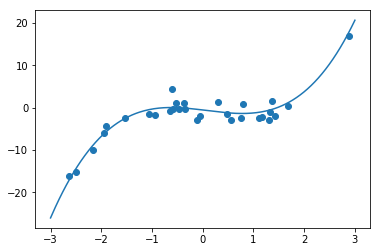

In [45]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

torch.manual_seed(123)
order = 3
W_gnd = torch.randn(order + 1)
left = -3
right = 3
variance = torch.randn(1)[0] * 10
# print('variance', variance)
# help(torch.arange)
x1 = torch.arange(left, right, (right - left) / 250)
# print(x1)

def expand_x(x1, order):
    N = x1.size()[0]
    x2 = torch.zeros(N, order + 1)
    for k in range(order + 1):
        x2[:, k] = x1.pow(k)
    return x2

x2 = expand_x(x1, order)
y_gnd = x2 @ W_gnd

num_samples = 30
x_samples = torch.rand(num_samples) * (right - left) + left
x_samples_aug = expand_x(x_samples, order=order)
y_samples = x_samples_aug @ W_gnd + torch.randn(num_samples) * np.sqrt(variance)


plt.plot(x1.numpy(), y_gnd.numpy())
# print('x_samples', x_samples)
# print('y_samples', y_samples)
plt.scatter(x_samples.numpy(), y_samples.numpy())
plt.show()


Looking at https://en.wikipedia.org/wiki/Bayesian_linear_regression, the posterior is:

$$
\def\Gauss{\mathcal{N}}
\def\IG{\mathcal{IG}}
    p(\mathbf{w}, \sigma^2 \mid \mathcal{Y}, \mathcal{X})
\propto \Gauss(\mathbf{w} \mid \mathbf{\mu}_n, \Prec_n)
\cdot
\IG(\sigma^2 \mid a_n, b_n)
$$

Where:

$$
\Prec_n = \X^T \X + \Prec_0
$$

$$
\def\X{\mathbf{X}}
\def\Prec{\mathbf{\Lambda}}
\def\muv{\mathbf{\mu}}
\def\wv{\mathbf{w}}
\def\yv{\mathbf{y}}
\mathbf{\mu}_n = (\X^T\X + \Prec_0)^{-1}
(\Prec_0 \muv_0 + \X^T \X \wv) \\
= \Prec_n^{-1}
(\Prec_0 \muv_0 + \X^T \yv)
$$

$$
a_n = a_0 + \frac{n}{2} \\
b_n = b_0 + \frac{1}{2}(
\yv^T \yv + \muv_0^T \Prec_0 \muv_0 - \muv_n^T \Prec_n \muv_n)
$$

In [58]:
a_0 = 1
b_0 = 1
# prec_0 = torch.zeros(order + 1, order + 1)
prec_0 = torch.eye(order + 1)
# print('prec_0', prec_0)
mu_0 = torch.zeros(order + 1, 1)

X = x_samples_aug
Y = y_samples.view(-1, 1)
N = num_samples

prec_n = X.transpose(0, 1) @ X + prec_0
# print('prec_n', prec_n)
mu_n = prec_n.inverse() @ ((prec_0 @ mu_0) + X.transpose(0, 1) @ Y)
# print('mu_n', mu_n)
a_n = a_0 + N / 2
b_n = b_0 + 0.5 * (Y.transpose(0, 1) @ Y + mu_0.transpose(0, 1) @ prec_0 @ mu_0 \
    - mu_n.transpose(0, 1) @ prec_n @ mu_n)


# print('mu_n', mu_n)
# print('a_n', a_n)
# print('b_n', b_n)

# sample from the dist

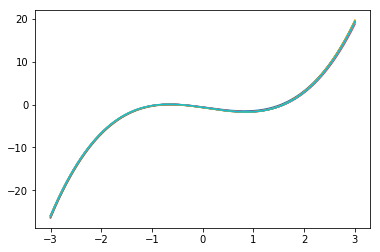

In [75]:
num_line_samples = 10

for i in range(num_line_samples):
    var = np.random.wald(a_n, b_n[0][0])
    cov = prec_n.inverse().numpy() / var
    w = np.random.multivariate_normal(mu_n.view(-1).numpy(), cov)
#     print('w', w)
#     print('a_n', a_n, 'b_n', b_n)
#     print('var', var)
    y = x2 @ torch.from_numpy(w).float()
    plt.plot(x1.numpy(), y.numpy())
plt.show()